In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/prichter/Documents/selenobot/src/')

# Detection task

"Detection task" refers to the ability of the classifier to identify a sequence as either an erroneously-truncated selenoprotein, or a full-length non-selenoprotein. For this task, we used full-length negative normal proteins as negative test cases. The negative cases did *not* include full-length selenoproteins, as full-length selenoproteins will not be present in the data we use to validate the model. The positive cases consisted of selenoproteins truncated at the *first* selenocysteine residue only. 

In [3]:
# Define the data and figure directories. 
DETECT_DATA_DIR = '/home/prichter/Documents/selenobot/data/detect' 
DATA_DIR = '/home/prichter/Documents/selenobot/data/' 
FIGURE_DIR = '/home/prichter/Documents/selenobot/figures/'

In [4]:
from src.classifiers import Classifier
from src.dataset import get_dataloader
import src.plot as plot
import src.classifiers as classifiers

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import pingouin as pg # Stuff for partial correlations. 

In [5]:
# Paths where the train and test data are stored. 
train_path = os.path.join(DETECT_DATA_DIR, 'train.csv')
test_path = os.path.join(DETECT_DATA_DIR, 'test.csv')
val_path = os.path.join(DETECT_DATA_DIR, 'val.csv')

In [6]:
train_data = pd.read_csv(train_path).set_index('id')
test_data = pd.read_csv(test_path).set_index('id')
val_data = pd.read_csv(val_path).set_index('id')

In [7]:
print('Training set size:', len(train_data))
print('Test set size:', len(test_data))
print('Validation set size:', len(val_data))
print()
print('TOTAL:', len(train_data) + len(test_data) + len(val_data))

Training set size: 471447
Test set size: 70620
Validation set size: 47155

TOTAL: 589222


Lucas pointed out that the barplot below could probably just be reported as a small table, as it doesn't provide much additional information. At the very least, I should probably get rid of the y-axis labels, as I think the relative proportion matters more, and change the orientation of the x-axis labels. 

In [8]:
# plot.plot_train_test_val_split(train_data, test_data, val_data)

## Benchmarking 

We are taking two different approaches to model benchmarking. Initially, we just used the amino acid content-based embedding as a benchmark, to confirm that the PLM-generated embeddings captured more than just compositional information (something about the structure and order of the input sequences). Amino acid content embeddings are generated using the `embedders.AacEmbedder` class. 

After comments from the CEMI presentation, we added an additional benchmark embedding space, based on sequence length alone. This is to make sure that the only reason the classifier is good isn't because the truncated sequences tend to be extra short (although I suspect the AAC embeddings already handle this to an extent). The length embeddings are generated using the `embedders.LengthEmbedder` class, 



In [9]:
# First load the data into a dataset object. 
aac_train_dataloader = get_dataloader(train_path, batch_size=1024, embedder='aac') 
aac_val_dataloader = get_dataloader(val_path, batch_size=1024, embedder='aac') 
aac_test_dataloader = get_dataloader(test_path, batch_size=1024, embedder='aac')

length_train_dataloader = get_dataloader(train_path, batch_size=1024, embedder='length') 
length_val_dataloader = get_dataloader(val_path, batch_size=1024, embedder='length') 
length_test_dataloader = get_dataloader(test_path, batch_size=1024, embedder='length') 

dataset.BalancedBatchSampler.__init__: Resampled 138060 selenoproteins and removed 227 to generate 595 batches of size 1024.
dataset.BalancedBatchSampler.__init__: Resampled 11590 selenoproteins and removed 377 to generate 57 batches of size 1024.
dataset.BalancedBatchSampler.__init__: Resampled 19882 selenoproteins and removed 390 to generate 88 batches of size 1024.
dataset.BalancedBatchSampler.__init__: Resampled 138060 selenoproteins and removed 227 to generate 595 batches of size 1024.
dataset.BalancedBatchSampler.__init__: Resampled 11590 selenoproteins and removed 377 to generate 57 batches of size 1024.
dataset.BalancedBatchSampler.__init__: Resampled 19882 selenoproteins and removed 390 to generate 88 batches of size 1024.


In [10]:
aac_model = Classifier(latent_dim=21, hidden_dim=8)
length_model = Classifier(latent_dim=1, hidden_dim=1)

In [11]:
aac_train_reporter = aac_model.fit(aac_train_dataloader, val=aac_val_dataloader, bce_loss_weight=1, epochs=10)
length_train_reporter = length_model.fit(length_train_dataloader, val=length_val_dataloader, bce_loss_weight=1, epochs=10)

classifiers.Classifier.train_: 100%|██████████| 10/10 [00:59<00:00,  6.00s/it, val_acc=0.5]


The training curves for the AAC and length embeddings are given below. Interestingly, in the top panel, it seems as though training loss exceeds validation loss. This is likely due to the large imbalance in the validation set, which contains only 6 percent truncated selenoproteins (as compared to the training set, which contains 25.4 percent truncated selenoproteins). This means that the validation set is a comparatively easier problem -- a low loss socre can be obtained by simply classifying everything as full-length.

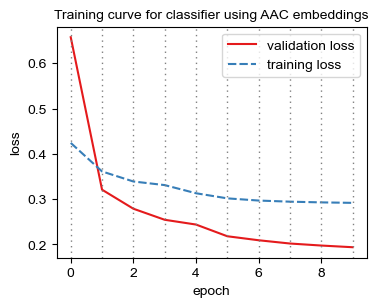

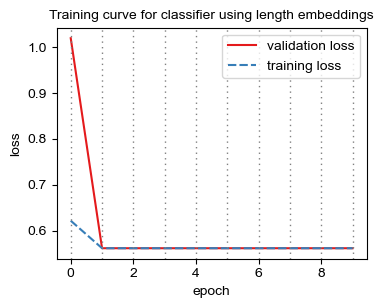

In [12]:
plot.plot_train_curve(aac_train_reporter, title='Training curve for classifier using AAC embeddings', path=os.path.join(FIGURE_DIR, 'aac_train_curve.png'))
plot.plot_train_curve(length_train_reporter, title='Training curve for classifier using length embeddings', path=os.path.join(FIGURE_DIR, 'length_train_curve.png'))

In [13]:
print('Final balanced accuracy for AAC embeddings on test data:', aac_model.test(aac_test_dataloader).get_test_accs()[0])
print('Final balanced accuracy for length embeddings on test data:', length_model.test(length_test_dataloader).get_test_accs()[0])

Final balanced accuracy for AAC embeddings on test data: 0.8973351680871212
Final balanced accuracy for length embeddings on test data: 0.5


The accuracy of the length-based classifier seems shockingly high to me. Let's take a look at the confusion matrix. We can see that the length model is essentially just always predicting negative. But then, why is the balanced accuracy? The first value `tp / (tp + fn)`, should be zero. *Update: I had `y_true` and `y_pred` switched in the input to the `sklearn` balanced accuracy function!*

In [14]:
(tn, fp, fn, tp) = length_model.test(length_test_dataloader).get_confusion_matrix()

print('Confusion matrix for length-based classifier:')
print('True negative:', tn)
print('False positive:', fp)
print('False negative:', fn)
print('True positive:', tp)

Confusion matrix for length-based classifier:
True negative: 67584
False positive: 0
False negative: 22528
True positive: 0


In [15]:
(tn, fp, fn, tp) = aac_model.test(aac_test_dataloader).get_confusion_matrix()

print('Confusion matrix for AAC-based classifier:')
print('True negative:', tn)
print('False positive:', fp)
print('False negative:', fn)
print('True positive:', tp)

Confusion matrix for AAC-based classifier:
True negative: 64939
False positive: 2645
False negative: 3744
True positive: 18784


## Protein language model embedding-based classification

In [16]:
# embedder=None to use the embeddings already stored in the file. 
plm_train_dataloader = get_dataloader(train_path, batch_size=1024, embedder='plm') 
plm_val_dataloader = get_dataloader(val_path, batch_size=1024, embedder='plm') 
plm_test_dataloader = get_dataloader(test_path, batch_size=1024, embedder='plm')

ValueError: dataset.get_dataloader: Embedder option must be one of aac, plm, or length.

In [ ]:
plm_model = Classifier(latent_dim=1024, hidden_dim=512)

In [ ]:
plm_train_reporter = plm_model.fit(plm_train_dataloader, val=plm_val_dataloader, epochs=10, bce_loss_weight=1)

classifiers.Classifier.train_: 100%|██████████| 10/10 [00:24<00:00,  2.42s/it, val_acc=0.99]


In [ ]:
thresholds = list(np.arange(0, 1.1, 0.1))

threshold_data = {}
threshold_data['plm'] = classifiers.test_thresholds(plm_model, plm_test_dataloader, thresholds=thresholds)
threshold_data['aac'] = classifiers.test_thresholds(aac_model, aac_test_dataloader, thresholds=thresholds)
threshold_data['length'] = classifiers.test_thresholds(length_model, length_test_dataloader, thresholds=thresholds)

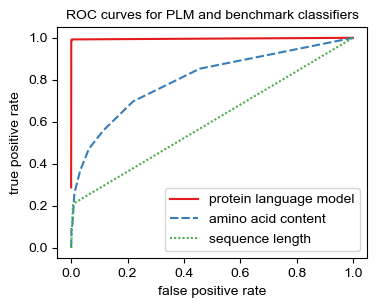

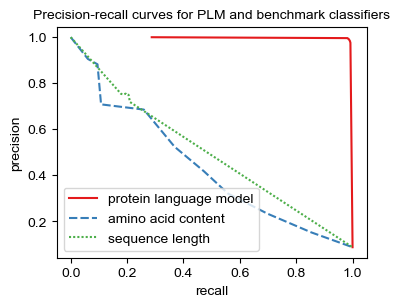

In [ ]:
plot.plot_receiver_operator_curves(threshold_data, title='ROC curves for PLM and benchmark classifiers', path=os.path.join(FIGURE_DIR, 'roc_curves.png')) 
plot.plot_precision_recall_curves(threshold_data, title='Precision-recall curves for PLM and benchmark classifiers', path=os.path.join(FIGURE_DIR, 'pr_curves.png')) 

## Model validation

Josh embedded all genomes in GTDB using the Prot-T5 model, and ran it through the trained classifier to select proteins which are likely to have been erroneously truncated. The proteins were sorted by genome, so data is reported for each indidual genome in GTDB. The genome ID is given as the `DataFrame` index. Column descriptions are given below. *What file in the GTDB repository did Josh use for embeddings?*

1. `total_hits` gives the total number of predicted selenoproteins in the genome. 
2. `hits_with_annotation` refers to the number of flagged potential selenoproteins which have annotations, generated using `kofamscan`. 
3. `total_genes` gives the total number of genes detected in the genome. 
4. `total_genes_with_annotation` gives the total number of genes successfully annotated with a KO group using `kofamscan`.
5. `selD_copy_num` is the number of copies of selD in the genome. The role of selD  is to provide reduced and active selenium forthe production of selenocysteine-carrying tRNA ([Bock et. al 1991](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1365-2958.1991.tb00722.x)).

Then, I added a column to the GTDB data which gives the ration of selenoprotein "hits" to total identified proteins. This will hopefully account for any bias towards large genomes being marked as having high selenoprotein content, just because they are larger. Also, the taxonomy data loaded above is parsed and added to the `DataFrame` in which the GTDB selenoprotein data is stored. 


In [ ]:
gtdb_data = pd.read_pickle('/home/prichter/Documents/selenobot/data/gtdb_r207/selenoprotein_results.30Sep2023.pkl')
print('Columns:', ', '.join(list(gtdb_data.columns)))

gtdb_data['genome_id'] = gtdb_data.index
gtdb_data['selenoprotein_ratio'] = gtdb_data['total_hits'] / gtdb_data['total_genes']

Columns: total_hits, hits_with_annotation, total_genes, total_genes_with_annotation, selD_copy_num


The first question I had about the data is which species contain the greatest number of flagged selenoproteins? In order to get more informative results about the types of organisms which are enriched for selenoproteins, I added taxonomical information to the data generated on GTDB. To do so, I first merged the taxonomy data for archaea and bacteria stored across two files on the GTDB repository.

In [ ]:
# What do the 53 and 120 after the archaea and bacteria filenames represent?
ar53_taxonomy_path = os.path.join(DATA_DIR, 'gtdb_r207', 'ar53_taxonomy_r207.tsv')
bac120_taxonomy_path = os.path.join(DATA_DIR, 'gtdb_r207', 'bac120_taxonomy_r207.tsv')

In [ ]:
# ! cat /home/prichter/Documents/selenobot/data/gtdb_08_rs214/ar53_taxonomy.tsv /home/prichter/Documents/selenobot/data/gtdb_08_rs214/bac120_taxonomy.tsv >> /home/prichter/Documents/selenobot/data/gtdb_08_rs214/taxonomy.tsv 
taxonomy_data = pd.concat([pd.read_csv(ar53_taxonomy_path, delimiter='\t', names=['genome_id', 'taxonomy']), pd.read_csv(bac120_taxonomy_path, delimiter='\t',  names=['genome_id', 'taxonomy'])])
taxonomy_data = parse_taxonomy_data(taxonomy_data)
taxonomy_data.head()

,genome_id,domain,phylum,class,order,family,genus,species
0,RS_GCF_000979375.1,Archaea,Halobacteriota,Methanosarcinia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina mazei
1,RS_GCF_000970165.1,Archaea,Halobacteriota,Methanosarcinia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina mazei
2,RS_GCF_000979555.1,Archaea,Halobacteriota,Methanosarcinia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina mazei
3,RS_GCF_000980105.1,Archaea,Halobacteriota,Methanosarcinia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina mazei
4,RS_GCF_000007065.1,Archaea,Halobacteriota,Methanosarcinia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina mazei


Before merging the taxonomy data with the results from running the model on GTDB, I want to confirm that some assumptions I am making about the `taxonomy_data` and the `gtdb_data` aren't going to trip me up (as I suspect they currently are). The issue I was having (and am no longer having) was due to the fact that I had downloaded data from the wrong GTDB release. This is fixed now!

In [ ]:
genome_ids_in_taxonomy_data = set(taxonomy_data['genome_id'])
genome_ids_in_gtdb_data = set(gtdb_data['genome_id'])

print('Number of genomes in taxonomy_data:', len(genome_ids_in_taxonomy_data))
print('Number of genomes in gtdb_data:', len(genome_ids_in_gtdb_data))
print('Number of genes in both taxonomy and gtdb -_data:', len(genome_ids_in_gtdb_data.intersection(genome_ids_in_taxonomy_data)))

Number of genomes in taxonomy_data: 317542
Number of genomes in gtdb_data: 65689
Number of genes in both taxonomy and gtdb -_data: 65689


In [ ]:
# Add taxonomy information to the gtdb_data.
gtdb_data = gtdb_data.merge(taxonomy_data, on='genome_id', how='inner')
gtdb_data.head()

,total_hits,hits_with_annotation,total_genes,total_genes_with_annotation,selD_copy_num,genome_id,selenoprotein_ratio,domain,phylum,class,order,family,genus,species
0,14,{'K01915': 1},1306,773,0,GB_GCA_014654065.1,0.01072,Bacteria,Proteobacteria,Alphaproteobacteria,Pelagibacterales,Pelagibacteraceae,Pelagibacter,Pelagibacter sp014654065
1,32,"{'K00179': 1, 'K00826': 1}",1496,722,0,GB_GCA_002479145.1,0.02139,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella sp002479145
2,178,"{'K00228': 1, 'K01126': 1, 'K01995': 1, 'K0199...",4682,2489,2,GB_GCA_014377155.1,0.038018,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,CAILRJ01,CAILRJ01 sp014377155
3,185,"{'K00118': 1, 'K00655': 1, 'K01077': 1, 'K0174...",2170,886,0,GB_GCA_903829855.1,0.085253,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,UBA953,UBA953,UBA953 sp903829855
4,11,{},600,284,0,GB_GCA_002923395.1,0.018333,Bacteria,Patescibacteria,Paceibacteria,Paceibacterales,HRBIN34,HRBIN34,HRBIN34 sp002923395


In [ ]:
# This value should be the same as before the merge. 
print('Length of merged gtdb_data:', len(gtdb_data))

Length of merged gtdb_data: 65689


### Correlation between genome quality and predicted selenoprotein ratio

One point which was brought up a few times at the CEMI poster presentation boils down to: How do we know the things we are predicting as selenoproteins are actually selenoproteins, and not just truncated regular proteins? To look into this, I first wanted to see if there was any correlation between genome quality and number of predicted selenoproteins. It also would be useful to control for any confounding factors, specifically length, as we have already shown (earlier) that length can, at least somewhat, predict whether or not a sequence is a selenoprotein. 

In [ ]:
bac120_metadata = pd.read_csv(os.path.join(DATA_DIR, 'gtdb_r207', 'bac120_metadata_r207.tsv'), delimiter='\t')
ar53_metadata = pd.read_csv(os.path.join(DATA_DIR, 'gtdb_r207', 'ar53_metadata_r207.tsv'), delimiter='\t')

metadata = pd.concat([bac120_metadata, ar53_metadata])

print('Columns:', ', '.join(list(metadata.columns)))
print(len(metadata), 'metadata entries prior to merge.')

Columns: accession, ambiguous_bases, checkm_completeness, checkm_contamination, checkm_marker_count, checkm_marker_lineage, checkm_marker_set_count, checkm_strain_heterogeneity, coding_bases, coding_density, contig_count, gc_count, gc_percentage, genome_size, gtdb_genome_representative, gtdb_representative, gtdb_taxonomy, gtdb_type_designation, gtdb_type_designation_sources, gtdb_type_species_of_genus, l50_contigs, l50_scaffolds, longest_contig, longest_scaffold, lsu_23s_contig_len, lsu_23s_count, lsu_23s_length, lsu_23s_query_id, lsu_5s_contig_len, lsu_5s_count, lsu_5s_length, lsu_5s_query_id, lsu_silva_23s_blast_align_len, lsu_silva_23s_blast_bitscore, lsu_silva_23s_blast_evalue, lsu_silva_23s_blast_perc_identity, lsu_silva_23s_blast_subject_id, lsu_silva_23s_taxonomy, mean_contig_length, mean_scaffold_length, mimag_high_quality, mimag_low_quality, mimag_medium_quality, n50_contigs, n50_scaffolds, ncbi_assembly_level, ncbi_assembly_name, ncbi_assembly_type, ncbi_bioproject, ncbi_bios

I am not totally sure what the rationale is behind the quality score, but it seems like a reasonable enough metric to use for determining how good the genomes are; it seems to somehow account for both the completeness and contamination estimates. The higher the quality score, the better the genome. 

In [ ]:
metadata = metadata.rename(columns={'accession':'genome_id'})
# CheckM contamination estimate <10%, quality score, defined as completeness - 5*contamination
metadata['checkm_quality_score'] = metadata['checkm_completeness'] - 5 * metadata['checkm_contamination']

# Add taxonomy information to the gtdb_data.
gtdb_data_with_metadata = gtdb_data.merge(metadata, on='genome_id', how='inner')

### Results on a model genome